In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.model_selection import train_test_split, GridSearchCV


# ==== USER SETTINGS ====
data_dir = "data/raw_data/"          # folder where .h5 files are stored
n_bins = 100                          # number of bins
x_range = (110, 160)                 # mass range in GeV
save_hist = True                    # change to False if you just want to view
output_dir = "data/generated_histograms/"  # folder to save npz
data_dir_hist = "data/generated_histograms/"  # folder where histograms are stored

Delanje histograma (vzame dosti spomina, vsaj 8gb mej fraj)

Loading data/raw_data/mc_bkg_new.h5 ...
Loading data/raw_data/mc_sig.h5 ...
Loading data/raw_data/data.h5 ...
Loading data/raw_data/mc_bkg_new.h5 ...
Loading data/raw_data/data.h5 ...
Plotted Data/Background ratio.


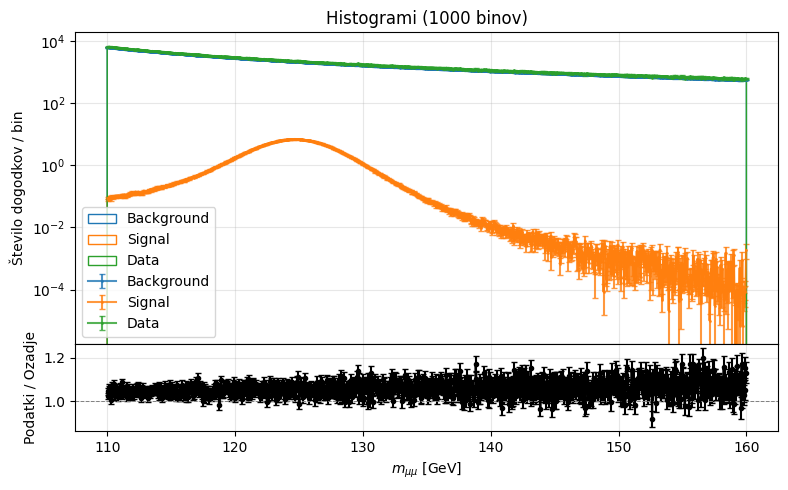

In [ ]:
bins_h = 1000

# Load data
def load_data(path):
    """Load .h5 dataset."""
    print(f"Loading {path} ...")
    return pd.read_hdf(path, key="ntuple")
    
def make_histogram(data, n_bins=bins_h, x_range=x_range):
    """Return bin centers, values, and errors for given dataset."""
    events = data["Muons_Minv_MuMu_Paper"]
    weights = data["CombWeight"]
    weights2 = weights ** 2

    values, edges = np.histogram(events, bins=n_bins, range=x_range, weights=weights)
    sum_w2, _ = np.histogram(events, bins=n_bins, range=x_range, weights=weights2)
    errors = np.sqrt(sum_w2)
    centers = 0.5 * (edges[1:] + edges[:-1])

    return centers, values, errors
# Plotting
datasets = {
    "Background": "mc_bkg_new",
    "Signal": "mc_sig",
    "Data": "data",
}

plt.figure(figsize=(8, 5))
colors = {"Background": "tab:blue", "Signal": "tab:orange", "Data": "tab:green"}

for label, name in datasets.items():
    data = load_data(os.path.join(data_dir, name + ".h5"))
    centers, values, errors = make_histogram(data, bins_h, x_range)

    plt.errorbar(centers, values, yerr=errors, label=label, color=colors[label],
                 markersize=1, capsize=2, alpha=0.8, fmt ='o-')

    plt.hist(centers, bins=bins_h, range=x_range, weights=values, histtype='step', color=colors[label], alpha=1, label=label)
    
    #os.makedirs(output_dir, exist_ok=True)
    #save_path = os.path.join(output_dir, f"{name}_histogram.npz")
    #np.savez(save_path, bin_edges=centers, bin_centers=centers, bin_values=values, bin_errors=errors)
    #print(f"Saved histogram to {save_path}")


plt.xlabel(r"$m_{\mu\mu}$ [GeV]")
plt.ylabel("Število dogodkov / bin")
plt.title(f"Histogrami ({bins_h} binov)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.yscale('log')

# Add measurements/background subplot under the main axes
fig = plt.gcf()
ax_main = plt.gca()
pos = ax_main.get_position()

# Shrink main plot to make room for the ratio plot
main_pos = [pos.x0, pos.y0 + 0.22 * pos.height, pos.width, pos.height * 0.78]
ax_main.set_position(main_pos)

# Create ratio (measurements/background) axes below, sharing x-axis
ax_ratio = fig.add_axes([pos.x0, pos.y0, pos.width, pos.height * 0.22], sharex=ax_main)

for i in range(1):  # just one iteration to plot once
    # load histograms for Data (measurements) and Background
    bkg_data = load_data(os.path.join(data_dir, datasets["Background"] + ".h5"))
    meas_data = load_data(os.path.join(data_dir, datasets["Data"] + ".h5"))
    _, bkg_vals, bkg_err = make_histogram(bkg_data, bins_h, x_range)
    _, meas_vals, meas_err = make_histogram(meas_data, bins_h, x_range)

    # compute Data / Background and propagated uncertainty
    eps = 1e-12
    mask = bkg_vals > 0
    meas_over_bkg = np.zeros_like(meas_vals, dtype=float)
    meas_over_bkg_err = np.zeros_like(meas_vals, dtype=float)

    meas_over_bkg[mask] = meas_vals[mask] / bkg_vals[mask]
    # propagate relative errors, guard against zero measured value
    rel_meas = np.where(meas_vals > 0, meas_err / np.maximum(meas_vals, eps), 0.0)
    rel_bkg = bkg_err / np.maximum(bkg_vals, eps)
    meas_over_bkg_err[mask] = meas_over_bkg[mask] * np.sqrt(rel_meas[mask] ** 2 + rel_bkg[mask] ** 2)

    # plot Data/Background
    ax_ratio.errorbar(centers, meas_over_bkg, yerr=meas_over_bkg_err, fmt='o-', color='black', markersize=3, capsize=2)
    ax_ratio.axhline(1.0, color='gray', linestyle='--', linewidth=0.7)
    print("Plotted Data/Background ratio.")

ax_ratio.set_xlabel(r"$m_{\mu\mu}$ [GeV]")
ax_ratio.set_ylabel("Podatki / Ozadje")
ax_ratio.grid(alpha=0.3)

plt.setp(ax_main.get_xticklabels(), visible=False)
plt.show()

Fitting

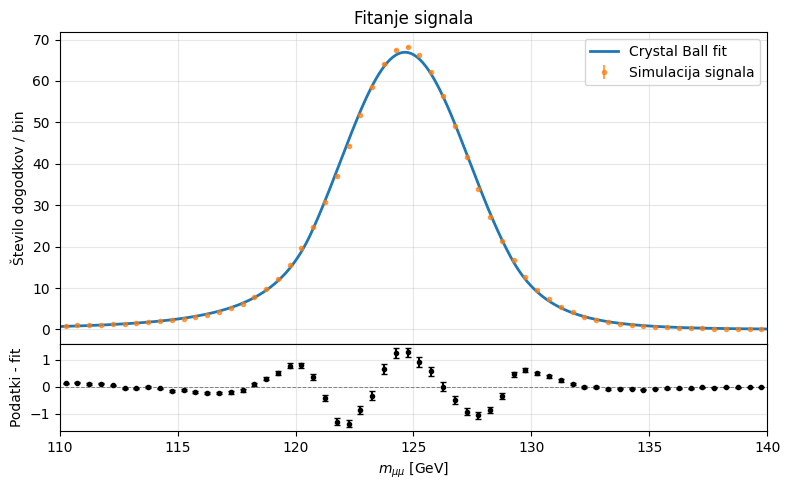

In [22]:
datasets = {
    "Background": "mc_bkg_new_histogram",
    "Signal": "mc_sig_histogram",
    "Data": "data_histogram",
}

save_fig = False  # change to False if you just want to view

def fit_background_polynomials():
    # Fit functions (example: exponential + polynomial term)
    def background_model1(x, a, b, c):
        """Simple 2nd-degree polynomial background model."""
        return a * np.exp(b * x) + c

    def background_model2(x, a, b, c, d):
        """More complex 3rd-degree polynomial background model."""
        return a * np.exp(b * x) + c * x + d

    def background_model3(x, a, b, c, d, e):
        """Even more complex 4th-degree polynomial background model."""
        return a * np.exp(b * x) + c * x**2 + d * x + e

    bkg_data = np.load(os.path.join(data_dir_hist, "mc_bkg_new_histogram.npz"))

    x_bkg, y_bkg, yerr_bkg = bkg_data["bin_centers"], bkg_data["bin_values"], bkg_data["bin_errors"]

    # Plot result
    plt.figure(figsize=(8, 5))


    for model in [background_model1, background_model2, background_model3]:
        #print(f"Model: {model.__name__}, Number of parameters: {model.__code__.co_argcount - 1}")
        # Fit the model to the background data
        # set a different initial guess depending on the model's parameter count
        npar = model.__code__.co_argcount - 1
        if npar == 3:
            # [a, b, c]
            p0 = [y_bkg.max(), -0.02, max(0.0, y_bkg.min())]
        elif npar == 4:
            # [a, b, c, d]
            p0 = [y_bkg.max(), -0.02, 0.1 * y_bkg.max(), max(0.0, y_bkg.min())]
        elif npar == 5:
            # [a, b, c, d, e]
            p0 = [y_bkg.max(), -0.02, 0.01 * y_bkg.max(), 0.1 * y_bkg.max(), max(0.0, y_bkg.min())]
        else:
            # generic fallback
            p0 = [y_bkg.max()] + [-0.01] * (npar - 1)

        #print("Initial guess p0:", p0)
        try:
            popt, pcov = curve_fit(model, x_bkg, y_bkg, p0=p0)
            perr = np.sqrt(np.diag(pcov))
            #print("Fitted parameters:")
            #for name, val, err in zip(["a", "b", "c", "d", "e"][:len(popt)], popt, perr):
                #print(f"{name} = {val:.3e} ± {err:.3e}")

            # Plot the fitted model
            x_fit = np.linspace(*x_range, 500)
            y_fit = model(x_fit, *popt)
            degree = max(0, npar - 1)
            plt.plot(x_fit, y_fit, lw=2, label=f"polinom stopnje {degree}")
        except Exception as e:
            print(f"Fit failed: {e}")
        print("-" * 40)




    ## Fit the model to the background data
    #p0 = [y_bkg.max(), -0.02, max(0.0, y_bkg.min())]
    #popt, pcov = curve_fit(background_model1, x_bkg, y_bkg, p0=p0)
    #perr = np.sqrt(np.diag(pcov))


    # Data histogram
    #plt.errorbar(x_data, y_data, yerr=yerr_data, fmt="o", color="black", label="Data", markersize=4, capsize=2)
    plt.errorbar(x_bkg, y_bkg, yerr=yerr_bkg, fmt="s", color="tab:blue", label="Simulacija ozadja", markersize=3, alpha=0.7)

    # Background simulation

    plt.xlabel(r"$m_{\mu\mu}$ [GeV]")
    plt.ylabel("Število dogodkov / bin")
    plt.title(f"Fitanje ozadja ({n_bins} binov, območje {x_range[0]}–{x_range[1]} GeV)")
    plt.legend()
    plt.ylim(4200, 70000)
    plt.yscale('log')
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', alpha=0.9)
    plt.tight_layout()

    if save_fig:
        plt.savefig("fit_background.png", dpi=300)
    plt.show()

# 0 is background, 1 is data
def fit_background_cms(i):

    # Fit function (CMS function)
    def cms_fit_function(m, a_1, a_2, a_3):
        m_Z, g_Z = 91.1876, 2.4952
        return np.exp(a_2 * m + a_3 * m**2) / ((m - m_Z) ** a_1 + (0.5 * g_Z) ** a_1)
    
    # Load background and data
    data_types = ["Background", "Data"]
    data_types_slo = ["Simulacija ozadja", "Podatki"]
    data = np.load(os.path.join(data_dir_hist, datasets[data_types[i]] + ".npz"))
    x_bkg, y_bkg, yerr_bkg = data["bin_centers"], data["bin_values"], data["bin_errors"]

    # Fit the model to the background data
    #p0 = np.array([3.288e+00, 2.997e-01, -1.011e-03])
    p0 = np.array([1.0, 1.0, 1.0])*1e-3
    #print("Initial guess p0:", p0)
    
    popt, pcov = curve_fit(cms_fit_function, x_bkg, y_bkg, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    #print("Fitted parameters:")
    #for name, val, err in zip(["a_1", "a_2", "a_3"], popt, perr):
    #    print(f"{name} = {val:.3e} ± {err:.3e}")

    plt.figure(figsize=(8, 5))
    # Plot the fitted model
    x_fit = np.linspace(*x_range, 500)
    y_fit = cms_fit_function(x_fit, *popt)
    plt.plot(x_fit, y_fit, lw=2, label=f"CMS fit function")
    

    # Plot result

    # Data histogram
    plt.errorbar(x_bkg, y_bkg, yerr=yerr_bkg, fmt="s", color="tab:blue", label= data_types_slo[i], markersize=3, alpha=0.7)

    # Background simulation

    plt.xlabel(r"$m_{\mu\mu}$ [GeV]")
    plt.ylabel("Število dogodkov / bin")
    plt.title(f"Fitanje ozadja (CMS funkcija)")
    plt.legend()
    #plt.ylim(3900, 100000)
    plt.yscale('log')
    plt.xlim(110, 160)
    plt.grid(which='minor', linestyle=':', alpha=0.9)
    plt.tight_layout()

    # Adding a subplot under the main axes to show the difference between the data and the fit
    fig = plt.gcf()
    ax_main = plt.gca()
    pos = ax_main.get_position()
    # Shrink main plot to make room for the ratio plot
    main_pos = [pos.x0, pos.y0 + 0.22 * pos.height, pos.width, pos.height * 0.78]
    ax_main.set_position(main_pos)
    # Create difference (data - fit) axes below, sharing x-axis
    ax_diff = fig.add_axes([pos.x0, pos.y0, pos.width, pos.height * 0.22], sharex=ax_main)
    y_diff = y_bkg - cms_fit_function(x_bkg, *popt)
    ax_diff.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax_diff.errorbar(x_bkg, y_diff, yerr=yerr_bkg, fmt='o', color='black', markersize=3, capsize=2)
    ax_diff.set_ylabel("Podatki - fit")
    ax_diff.set_xlabel(r"$m_{\mu\mu}$ [GeV]")
    ax_diff.set_ylim(-1500, 1500)
    ax_diff.grid()
    plt.setp(ax_main.get_xticklabels(), visible=False)
    

    if save_fig:
        plt.savefig("fit_background.png", dpi=300)
    plt.show()

def fit_background_cms_exclude(exclude_window=(120, 130)):
    # Fit function (CMS function)
    def cms_fit_function(m, a_1, a_2, a_3):
        m_Z, g_Z = 91.1876, 2.4952
        return np.exp(a_2 * m + a_3 * m**2) / ((m - m_Z) ** a_1 + (0.5 * g_Z) ** a_1)

    data = np.load(os.path.join(data_dir_hist, "data_histogram.npz"))
    x_all, y_all, yerr_all = data["bin_centers"], data["bin_values"], data["bin_errors"]

    # Create mask to exclude specified window (so signal region is not used in the fit)
    lo, hi = exclude_window
    mask = ~((x_all >= lo) & (x_all <= hi))
    x_fit = x_all[mask]
    y_fit = y_all[mask]
    yerr_fit = yerr_all[mask]

    # Initial guess
    p0 = np.array([1.0, 1.0, 1.0]) * 1e-3
    #print("Initial guess p0:", p0)

    try:
        popt, pcov = curve_fit(
            cms_fit_function,
            x_fit,
            y_fit,
            sigma=yerr_fit,
            p0=p0,
            maxfev=10000
        )
        perr = np.sqrt(np.diag(pcov))
        #print("Fitted parameters:")
        #for name, val, err in zip(["a_1", "a_2", "a_3"], popt, perr):
        #    print(f"{name} = {val:.3e} ± {err:.3e}")
    except Exception as e:
        print(f"Fit failed: {e}")
        return

    # Plot result
    plt.figure(figsize=(8, 5))
    x_smooth = np.linspace(*x_range, 500)
    y_smooth = cms_fit_function(x_smooth, *popt)
    plt.plot(x_smooth, y_smooth, lw=2, label="CMS fit funkcija (izvzeto {:.0f}-{:.0f} GeV)".format(lo, hi))

    # Show the full histogram (including excluded region) for context
    plt.errorbar(x_all, y_all, yerr=yerr_all, fmt="s", color="tab:blue",
                 label="Podatki", markersize=3, alpha=0.7)

    # Shade the excluded window so it's visible on the plot
    plt.axvspan(lo, hi, color="gray", alpha=0.25, label=f"Izvzeto območje {lo}-{hi} GeV")

    plt.xlabel(r"$m_{\mu\mu}$ [GeV]")
    plt.ylabel("Število dogodkov / bin")
    plt.title("Fitanje ozadja (CMS funkcija) — ekskluzija signala")
    plt.legend()
    plt.yscale("log")
    plt.xlim(x_range)
    plt.grid(which='minor', linestyle=':', alpha=0.9)
    plt.tight_layout()

    # Adding a subplot under the main axes to show the difference between the data and the fit
    fig = plt.gcf()
    ax_main = plt.gca()
    pos = ax_main.get_position()
    # Shrink main plot to make room for the ratio plot
    main_pos = [pos.x0, pos.y0 + 0.22 * pos.height, pos.width, pos.height * 0.78]
    ax_main.set_position(main_pos)
    # Create difference (data - fit) axes below, sharing x-axis
    ax_diff = fig.add_axes([pos.x0, pos.y0, pos.width, pos.height * 0.22], sharex=ax_main)
    y_diff = y_all - cms_fit_function(x_all, *popt)
    ax_diff.axhline(0, color="gray", linestyle="--", linewidth=0.7)
    ax_diff.errorbar(x_all, y_diff, yerr=yerr_all, fmt="o", color="black", markersize=3, capsize=2)
    ax_diff.set_ylabel("Podatki - fit")
    ax_diff.set_xlabel(r"$m_{\mu\mu}$ [GeV]")
    ax_diff.grid()
    ax_diff.set_ylim(-1500, 1500)
    plt.setp(ax_main.get_xticklabels(), visible=False)

    if save_fig:
        plt.savefig("fit_background_exclude_window.png", dpi=800)
    plt.show()

def fit_signal_crystalball():

    # Fit function (Crystal Ball)
    def CrystalBall(x, A, aL, aR, nL, nR, mCB, sCB):
        condlist = [
            (x - mCB) / sCB <= -aL,
            (x - mCB) / sCB >= aR,
        ]
        funclist = [
            lambda x: A
            * (nL / np.abs(aL)) ** nL
            * np.exp(-(aL**2) / 2)
            * (nL / np.abs(aL) - np.abs(aL) - (x - mCB) / sCB) ** (-nL),
            lambda x: A
            * (nR / np.abs(aR)) ** nR
            * np.exp(-(aR**2) / 2)
            * (nR / np.abs(aR) - np.abs(aR) + (x - mCB) / sCB) ** (-nR),
            lambda x: A * np.exp(-((x - mCB) ** 2) / (2 * sCB**2)),
        ]
        return np.piecewise(x, condlist, funclist)

    sign_data = np.load(os.path.join(data_dir_hist, "mc_sig_histogram.npz"))
    x_sign, y_sign, yerr_sign = sign_data["bin_centers"], sign_data["bin_values"], sign_data["bin_errors"]

    popt, pcov = curve_fit(
        CrystalBall,
        x_sign,
        y_sign,
        sigma= yerr_sign,
        p0=[133.0, 1.5, 1.5, 3.7, 9.6, 124.5, 3.0],
        )

    std = np.sqrt(np.diag(pcov))
    #print("Fitted parameters:")
    #for name, val, err in zip(["A", "aL", "aR", "nL", "nR", "mCB", "sCB"], popt, std):
    #    print(f"{name} = {val:.3e} ± {err:.3e}")
    x_range2 = (110,140)
    plt.figure(figsize=(8, 5))
    # Plot the fitted model
    x_fit = np.linspace(*x_range2, 500)
    y_fit = CrystalBall(x_fit, *popt)
    plt.plot(x_fit, y_fit, lw=2, label=f'Crystal Ball fit')
    # Data histogram
    plt.errorbar(x_sign, y_sign, yerr=yerr_sign, fmt="o", color="tab:orange", label="Simulacija signala", markersize=3, alpha=0.7)
    
    # Background simulation
    plt.xlabel(r"$m_{\mu\mu}$ [GeV]")
    plt.ylabel("Število dogodkov / bin")
    plt.title(f"Fitanje signala")
    plt.legend()
    plt.grid(alpha=0.3)
    #plt.yscale('log')
    plt.xlim(110, 140)
    plt.grid(which='minor', linestyle=':', alpha=0.9)
    plt.tight_layout()

    # Adding a subplot under the main axes to show the difference between the data and the fit
    fig = plt.gcf()
    ax_main = plt.gca()
    pos = ax_main.get_position()
    # Shrink main plot to make room for the ratio plot
    main_pos = [pos.x0, pos.y0 + 0.22 * pos.height, pos.width, pos.height * 0.78]
    ax_main.set_position(main_pos)
    # Create difference (data - fit) axes below, sharing x-axis
    ax_diff = fig.add_axes([pos.x0, pos.y0, pos.width, pos.height * 0.22], sharex=ax_main)
    y_diff = y_sign - CrystalBall(x_sign, *popt)
    ax_diff.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax_diff.errorbar(x_sign, y_diff, yerr=yerr_sign, fmt='o', color='black', markersize=3, capsize=2)
    ax_diff.set_ylabel("Podatki - fit")
    ax_diff.set_xlabel(r"$m_{\mu\mu}$ [GeV]")
    ax_diff.grid(alpha=0.3)
    plt.setp(ax_main.get_xticklabels(), visible=False)


    if save_fig:
        plt.savefig("fit_signal.png", dpi=300)
    plt.show()

#fit_background_polynomials()
#fit_background_cms(0)
#fit_background_cms_exclude((120, 130))
fit_signal_crystalball()

Modeliranje podatkov

/home/jurij/Documents/Faks/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


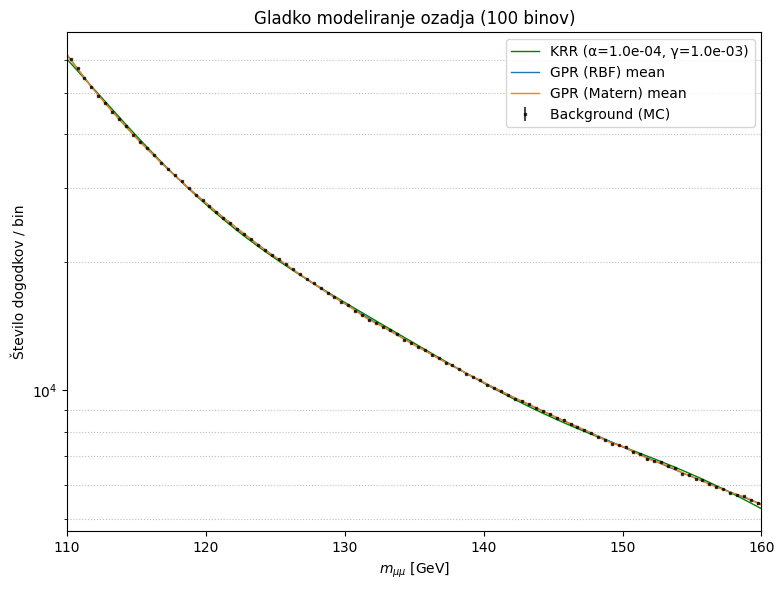

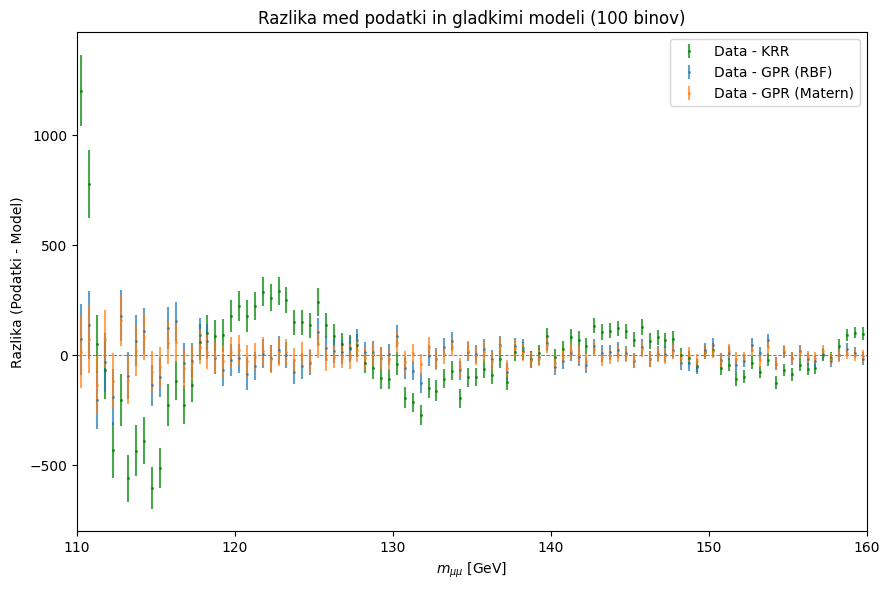

In [29]:

# Modeling the data with kernel ridge regression or gaussian regression

def load_hist():
    #Background
    bkg_data = np.load(os.path.join(data_dir_hist, datasets["Background"] + ".npz"))
    x_bkg = bkg_data["bin_centers"]
    y_bkg = bkg_data["bin_values"]
    yerr_bkg = bkg_data["bin_errors"]
    #Signal
    sign_data = np.load(os.path.join(data_dir_hist, datasets["Signal"] + ".npz"))
    x_sign = sign_data["bin_centers"]
    y_sign = sign_data["bin_values"]
    yerr_sign = sign_data["bin_errors"]
    #Data
    data_data = np.load(os.path.join(data_dir_hist, datasets["Data"] + ".npz"))
    x_data = data_data["bin_centers"]
    y_data = data_data["bin_values"]
    yerr_data = data_data["bin_errors"]
    return x_bkg, y_bkg, yerr_bkg, x_sign, y_sign, yerr_sign, x_data, y_data, yerr_data

x_bkg, y_bkg, yerr_bkg, x_sign, y_sign, yerr_sign, x_data, y_data, yerr_data = load_hist()


# KRR hyperparams (you can tweak)
krr_alpha = 1e-2              # regularization strength (lambda)
krr_gamma = None              # gamma for RBF kernel; if None, 1/median(dist^2) used below

# GPR hyperparams
gpr_kernel = 1.0 * RBF(length_scale=5.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1.0)
gpr_n_restarts = 5            # times to restart optimizer

def median_gamma(X):
    # heuristic for RBF gamma = 1/(2*l^2) where l^2 ~ median pairwise squared distance
    d = np.subtract.outer(X, X)**2
    med = np.median(d[np.triu_indices_from(d, k=1)])
    if med <= 0:
        med = np.mean(d[np.triu_indices_from(d, k=1)]) + 1e-8
    return 1.0 / (2.0 * med)

# Prepare arrays for regressors (sklearn needs 2D X)
X = x_bkg.reshape(-1, 1)
y = y_bkg.copy()
y_var = (yerr_bkg ** 2)  # variance per bin (use as observation noise for GPR)

# Tune KRR
param_grid = {
    "alpha": np.logspace(-4, 0, 10),     # 1e-4 to 1
    "gamma": np.logspace(-3, 1, 10),     # 1e-3 to 10
}
krr = KernelRidge(kernel="rbf")
grid = GridSearchCV(krr, param_grid, cv=3, scoring="neg_mean_squared_error")
grid.fit(X, y)

best_krr = grid.best_estimator_

x_dense = np.linspace(*x_range, 1000).reshape(-1, 1)
y_krr = best_krr.predict(x_dense)

# Define kernels for GPR
kernels = {
    "RBF": 1.0 * RBF(length_scale=5.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(),
    "Matern": 1.0 * Matern(length_scale=5.0, nu=1.5, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(),
}

gpr_results = {}
for name, kernel in kernels.items():
    gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5)
    gpr.fit(X, y)
    mean, std = gpr.predict(x_dense, return_std=True)
    gpr_results[name] = (mean, std, gpr.kernel_)

# Plot results
plt.figure(figsize=(8,6))
plt.errorbar(x_bkg, y_bkg, yerr=yerr_bkg, fmt='s', color='black', label='Background (MC)', markersize=2, alpha=0.7)
plt.plot(x_dense, y_krr, color='green', lw=1, label=f'KRR (α={grid.best_params_["alpha"]:.1e}, γ={grid.best_params_["gamma"]:.1e})')

for name, (mean, std, _) in gpr_results.items():
    plt.plot(x_dense, mean, lw=1, label=f'GPR ({name}) mean')

plt.xlabel(r"$m_{\mu\mu}$ [GeV]")
plt.ylabel("Število dogodkov / bin")
plt.title(f"Gladko modeliranje ozadja ({n_bins} binov)")
plt.legend()
plt.tight_layout()
plt.yscale('log')
plt.xlim(110, 160)
plt.grid(which='minor', linestyle=':', alpha=0.8)

if save_fig:
    plt.savefig("smoothed_background_tuned.png", dpi=800)
plt.show()

# Plot now the difference between the models and the data and make a hline on 0 (data - models (so KRR and GPR))
plt.figure(figsize=(9,6))
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
X = x_bkg.reshape(-1, 1) # full range including signal region
plt.errorbar(x_bkg, y_bkg - best_krr.predict(X), yerr=yerr_bkg, fmt='s',
             label='Data - KRR', markersize=1, alpha=0.7, color='green')
for name, (mean, std, _) in gpr_results.items():
    mean_at_X = np.interp(x_bkg, x_dense.ravel(), mean)
    plt.errorbar(x_bkg, y_bkg - mean_at_X, yerr=yerr_bkg, fmt='o', label=f'Data - GPR ({name})', markersize=1, alpha=0.7)
plt.xlabel(r"$m_{\mu\mu}$ [GeV]")
plt.ylabel("Razlika (Podatki - Model)")
plt.title(f"Razlika med podatki in gladkimi modeli ({n_bins} binov)")
plt.legend()
plt.xlim(110, 160)
plt.tight_layout()
plt.grid(which='minor', linestyle=':')
plt.show()

Odrežemo del s signalom

/home/jurij/Documents/Faks/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


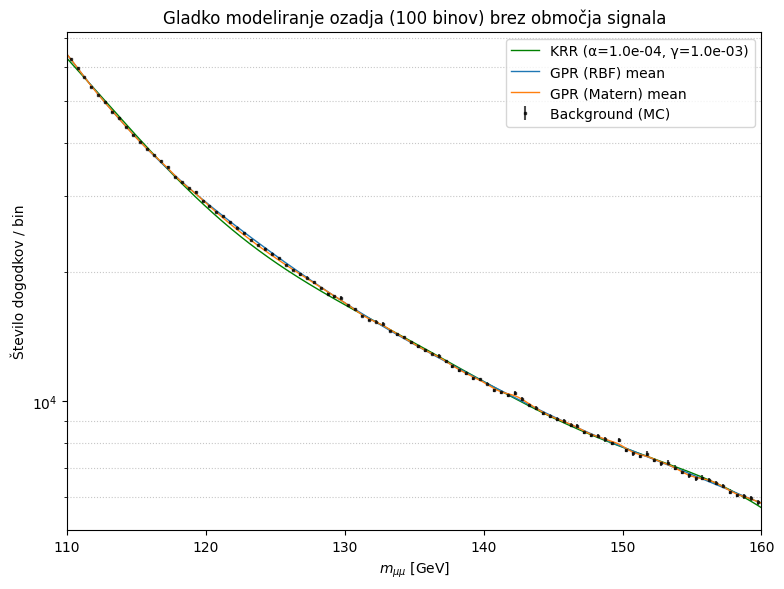

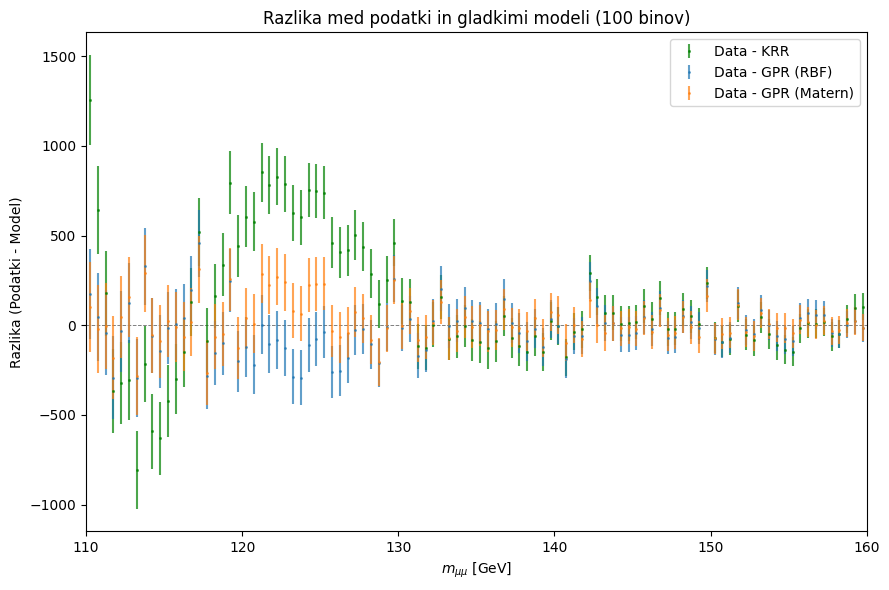

In [32]:

# Modeling the data with kernel ridge regression or gaussian regression

def load_hist():
    #Background
    bkg_data = np.load(os.path.join(data_dir_hist, datasets["Background"] + ".npz"))
    x_bkg = bkg_data["bin_centers"]
    y_bkg = bkg_data["bin_values"]
    yerr_bkg = bkg_data["bin_errors"]
    #Signal
    sign_data = np.load(os.path.join(data_dir_hist, datasets["Signal"] + ".npz"))
    x_sign = sign_data["bin_centers"]
    y_sign = sign_data["bin_values"]
    yerr_sign = sign_data["bin_errors"]
    #Data
    data_data = np.load(os.path.join(data_dir_hist, datasets["Data"] + ".npz"))
    x_data = data_data["bin_centers"]
    y_data = data_data["bin_values"]
    yerr_data = data_data["bin_errors"]
    return x_bkg, y_bkg, yerr_bkg, x_sign, y_sign, yerr_sign, x_data, y_data, yerr_data

x_bkg0, y_bkg0, yerr_bkg0, x_sign, y_sign, yerr_sign, x_data, y_data, yerr_data = load_hist()

# Exclude the signal region from 120 to 130 GeV and use the IRL data (not background)
mask = ((x_data < 120) | (x_data > 130))
x_bkg = x_data[mask]
y_bkg = y_data[mask]
yerr_bkg = yerr_data[mask]

# KRR hyperparams (you can tweak)
krr_alpha = 1e-2              # regularization strength (lambda)
krr_gamma = None              # gamma for RBF kernel; if None, 1/median(dist^2) used below

# GPR hyperparams
gpr_kernel = 1.0 * RBF(length_scale=5.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1.0)
gpr_n_restarts = 5            # times to restart optimizer

def median_gamma(X):
    # Heuristic for RBF gamma = 1/(2*l^2) where l^2 ~ median pairwise squared distance
    d = np.subtract.outer(X, X)**2
    med = np.median(d[np.triu_indices_from(d, k=1)])
    if med <= 0:
        med = np.mean(d[np.triu_indices_from(d, k=1)]) + 1e-8
    return 1.0 / (2.0 * med)

# Prepare arrays for regressors (sklearn needs 2D X)
X = x_bkg.reshape(-1, 1)
y = y_bkg.copy()
y_var = (yerr_bkg ** 2)  # variance per bin (use as observation noise for GPR)

# Tune KRR
param_grid = {
    "alpha": np.logspace(-4, 0, 10),     # 1e-4 to 1
    "gamma": np.logspace(-3, 1, 10),     # 1e-3 to 10
}
krr = KernelRidge(kernel="rbf")
grid = GridSearchCV(krr, param_grid, cv=3, scoring="neg_mean_squared_error")
grid.fit(X, y)

best_krr = grid.best_estimator_

x_dense = np.linspace(*x_range, 1000).reshape(-1, 1)
y_krr = best_krr.predict(x_dense)

# Tune GPR
kernels = {
    "RBF": 1.0 * RBF(length_scale=5.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(),
    "Matern": 1.0 * Matern(length_scale=5.0, nu=1.5, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(),
}

gpr_results = {}
for name, kernel in kernels.items():
    gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5)
    gpr.fit(X, y)
    mean, std = gpr.predict(x_dense, return_std=True)
    gpr_results[name] = (mean, std, gpr.kernel_)

# Plot results
plt.figure(figsize=(8,6))
plt.errorbar(x_data, y_data, yerr=yerr_data, fmt='s', color='black', label='Background (MC)', markersize=2, alpha=0.7)
plt.plot(x_dense, y_krr, color='green', lw=1, label=f'KRR (α={grid.best_params_["alpha"]:.1e}, γ={grid.best_params_["gamma"]:.1e})')

for name, (mean, std, _) in gpr_results.items():
    plt.plot(x_dense, mean, lw=1, label=f'GPR ({name}) mean')

plt.xlabel(r"$m_{\mu\mu}$ [GeV]")
plt.ylabel("Število dogodkov / bin")
plt.title(f"Gladko modeliranje ozadja ({n_bins} binov) brez območja signala")
plt.legend()
plt.tight_layout()
plt.yscale('log')
plt.grid(which='minor', linestyle=':', alpha=0.7)
plt.xlim(110,160)

if save_fig:
    plt.savefig("smoothed_background_tuned.png", dpi=800)
plt.show()

# Plot now the difference between the models and the data and make a hline on 0 (data - models (so KRR and GPR))
plt.figure(figsize=(9,6))
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
X = x_data.reshape(-1, 1) # full range including signal region
plt.errorbar(x_data, y_data - best_krr.predict(X), yerr=yerr_data, fmt='s',
             label='Data - KRR', markersize=1, alpha=0.7, color='green')
for name, (mean, std, _) in gpr_results.items():
    mean_at_X = np.interp(x_data, x_dense.ravel(), mean)
    plt.errorbar(x_data, y_data - mean_at_X, yerr=yerr_data, fmt='o', label=f'Data - GPR ({name})', markersize=1, alpha=0.7)
plt.xlabel(r"$m_{\mu\mu}$ [GeV]")
plt.ylabel("Razlika (Podatki - Model)")
plt.title(f"Razlika med podatki in gladkimi modeli ({n_bins} binov)")
plt.legend()
plt.grid(which='minor', linestyle=':', alpha=0.9)
plt.xlim(110,160)
plt.tight_layout()
plt.show()

Fitanje CB na razliko med podatki in fiti

/tmp/ipykernel_4200/3171138195.py:10: RuntimeWarning: overflow encountered in scalar power
  * (nL / np.abs(aL)) ** nL
/tmp/ipykernel_4200/3171138195.py:9: RuntimeWarning: invalid value encountered in multiply
  lambda x: A
/tmp/ipykernel_4200/3171138195.py:14: RuntimeWarning: overflow encountered in scalar power
  * (nR / np.abs(aR)) ** nR
/tmp/ipykernel_4200/3171138195.py:13: RuntimeWarning: invalid value encountered in multiply
  lambda x: A
/tmp/ipykernel_4200/3171138195.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(
/tmp/ipykernel_4200/3171138195.py:10: RuntimeWarning: invalid value encountered in scalar power
  * (nL / np.abs(aL)) ** nL
/tmp/ipykernel_4200/3171138195.py:12: RuntimeWarning: invalid value encountered in power
  * (nL / np.abs(aL) - np.abs(aL) - (x - mCB) / sCB) ** (-nL),
/tmp/ipykernel_4200/3171138195.py:14: RuntimeWarning: invalid value encountered in scalar power
  * (nR / np.abs(aR)) ** nR
/tmp/ipykernel_420

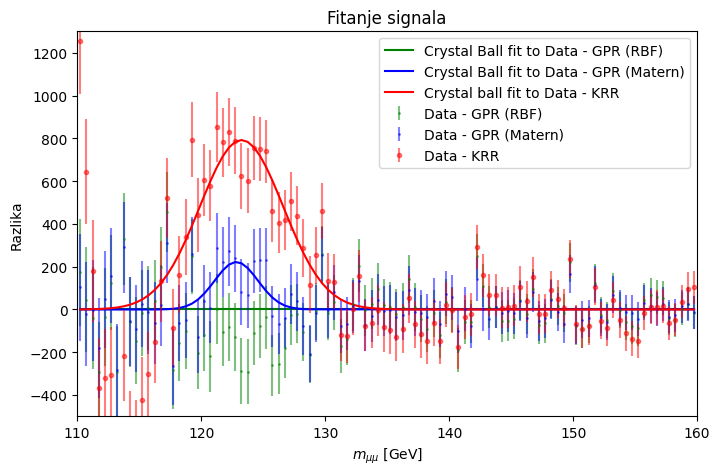

In [33]:
#Fitting the difference between the data and the background model with Crystal Ball function

def CrystalBall(x, A, aL, aR, nL, nR, mCB, sCB, a):
    condlist = [
        (x - mCB) / sCB <= -aL,
        (x - mCB) / sCB >= aR,
    ]
    funclist = [
        lambda x: A
        * (nL / np.abs(aL)) ** nL
        * np.exp(-(aL**2) / 2)
        * (nL / np.abs(aL) - np.abs(aL) - (x - mCB) / sCB) ** (-nL),
        lambda x: A
        * (nR / np.abs(aR)) ** nR
        * np.exp(-(aR**2) / 2)
        * (nR / np.abs(aR) - np.abs(aR) + (x - mCB) / sCB) ** (-nR),
        lambda x: A * np.exp(-((x - mCB) ** 2) / (2 * sCB**2)),
    ]
    return a*np.piecewise(x, condlist, funclist)

# Get the difference between data and KRR model

y_diff = y_data - best_krr.predict(x_data.reshape(-1, 1))
yerr_diff = yerr_data
# Fit the Crystal Ball function to the difference

# Scaling factor
a = 2.0

popt, pcov = curve_fit(
    CrystalBall,
    x_data,
    y_diff,
    sigma=yerr_diff,
    p0=[133.0, 1.5, 1.5, 3.7, 9.6, 124.5, 3.0, a],
    )
std = np.sqrt(np.diag(pcov))
fit_values = CrystalBall(x_data, *popt)


# Adding and plotting the difference between the data and the GPR background model fits and fitting the CB function to it

plt.figure(figsize=(8, 5))
colors = ["green", "blue"]
for name, (mean, std, _) in gpr_results.items():
    mean_at_X = np.interp(x_data, x_dense.ravel(), mean)
    y_diff_gpr = y_data - mean_at_X
    yerr_diff_gpr = yerr_data
    popt_gpr, pcov_gpr = curve_fit(
        CrystalBall,
        x_data,
        y_diff_gpr,
        sigma=yerr_diff_gpr,
        p0=[133.0, 1.5, 1.5, 3.7, 9.6, 124.5, 3.0, a],
        )
    std_gpr = np.sqrt(np.diag(pcov_gpr))
    fit_values_gpr = CrystalBall(x_data, *popt_gpr)
    # Plot the difference
    index = 0 if name == "RBF" else 1
    plt.errorbar(x_data, y_diff_gpr, yerr=yerr_diff_gpr, fmt='o', label=f'Data - GPR ({name})', markersize=1, alpha=0.5, color=colors[index])
    plt.plot(x_data, fit_values_gpr, label=f'Crystal Ball fit to Data - GPR ({name})', color=colors[index])

#print("Fitted parameters:")
#for name, val, err in zip(["A", "aL", "aR", "nL", "nR", "mCB", "sCB"], popt, std):
#    print(f"{name} = {val:.3e} ± {err:.3e}")

# Plot the fit result 
plt.errorbar(x_data, y_diff, yerr=yerr_diff, fmt="o", label="Data - KRR", markersize=3, alpha=0.5, color="red")
plt.plot(x_data, fit_values, label="Crystal ball fit to Data - KRR", color="red")
plt.title("Fitanje signala")
plt.xlabel(r"$m_{\mu\mu}$ [GeV]")
plt.ylabel("Razlika")
plt.xlim(110, 160)
plt.ylim(-500, 1300)
plt.legend()
plt.show()